# Dataset

# Classification

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
import umap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from torch.utils.data import DataLoader
from data_loader import SensorDataset, load_test_data, load_train_data
from models.cnn_model import CNNModel
from sklearn.preprocessing import StandardScaler
from collections import Counter

# Load the trained model
MODEL_PATH = "./output_model/out_20_1.pth"
TRAIN_DIR = "./dataset/train"
TEST_DIR = "dataset/test"
WINDOW_SIZE = 20
BATCH_SIZE = 20
NUM_CLASSES = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel(num_classes=NUM_CLASSES, window_size=WINDOW_SIZE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

scaler = StandardScaler()

/var/folders/1b/x02b24d16rbf3gjfvngp6hqw0000gn/T/ipykernel_83754/2567480616.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH,

In [11]:
# Load test data and normalize
X_train, y_train, _ = load_train_data(TRAIN_DIR, WINDOW_SIZE)  # Get training data
scaler = StandardScaler()
X_train_flat = X_train.reshape(-1, X_train.shape[-1])  # Flatten for scaling
scaler.fit(X_train_flat)
X_test, y_test = load_test_data(TEST_DIR, WINDOW_SIZE, scaler)
test_dataset = SensorDataset(X_test, y_test, one_hot=True, num_classes=NUM_CLASSES)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Collect true and predicted labels
y_true, y_pred = [], []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        _, preds = torch.max(outputs, 1)
        y_true.extend(torch.argmax(batch_y, dim=1).cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

ValueError: too many values to unpack (expected 3)

In [39]:
def visualize_features(X, y, method='PCA'):
    if method == 'PCA':
        reducer = PCA(n_components=2)
        X_reduced = reducer.fit_transform(X.reshape(X.shape[0], -1))
    
    elif method == 'TSNE':
        reducer = TSNE(n_components=2, perplexity=30)
        X_reduced = reducer.fit_transform(X.reshape(X.shape[0], -1))
    
    elif method == 'LDA':
        reducer = LDA(n_components=2)
        X_reduced = reducer.fit_transform(X.reshape(X.shape[0], -1), y)  # LDA needs labels
    
    elif method == 'UMAP':
        reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.3)  # Fixed UMAP import
        X_reduced = reducer.fit_transform(X.reshape(X.shape[0], -1))
    
    elif method == 'Isomap':
        reducer = Isomap(n_components=2, n_neighbors=10)
        X_reduced = reducer.fit_transform(X.reshape(X.shape[0], -1))
    
    else:
        raise ValueError("Unsupported method. Choose from PCA, TSNE, LDA, UMAP, Isomap.")

    # Plot the results
    plt.figure(figsize=(7, 6))
    sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=y, palette='Set1')
    plt.title(f"Feature Representation using {method}")
    plt.show()


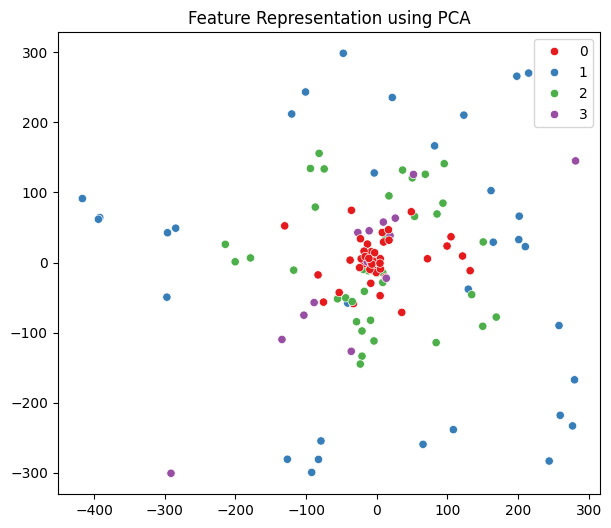

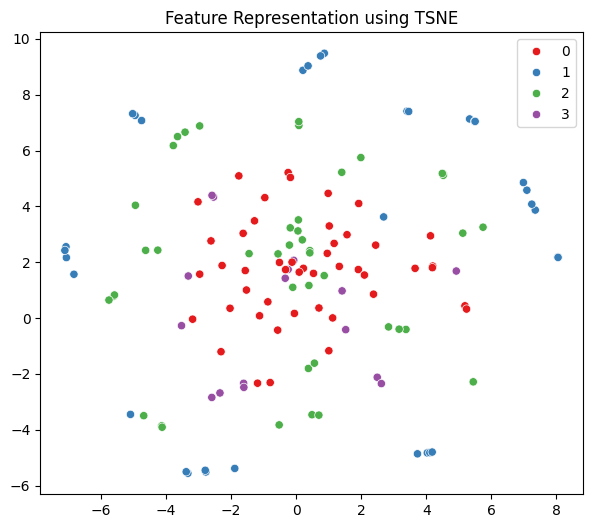

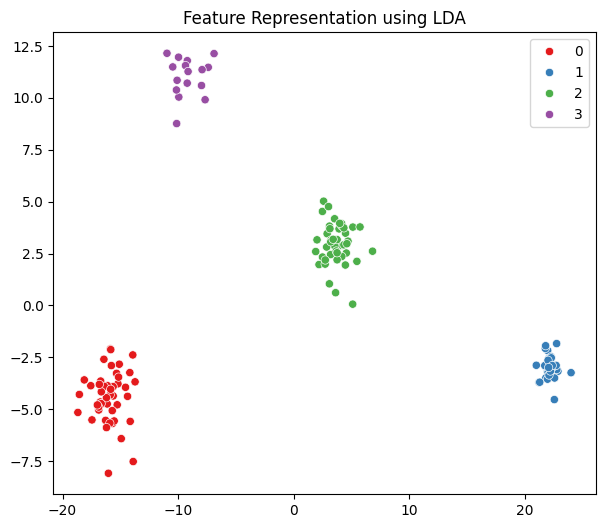

AttributeError: module 'umap' has no attribute 'UMAP'

In [40]:

# Flatten test set for visualization
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Apply PCA, t-SNE, LDA, UMAP, and Isomap
methods = ['PCA', 'TSNE', 'LDA', 'UMAP', 'Isomap']
for method in methods:
    visualize_features(X_test_flat, y_test, method=method)

# Prediction